# TP 1: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range
    
    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ] y_pred c'est mu_pred 
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot
      
    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])
    
    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")   
    
    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [3]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

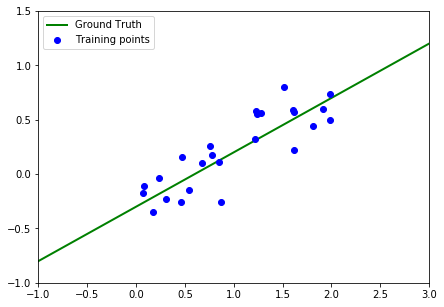

In [4]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [22]:
x=dataset_linear['X_train']
n = len(x)
o = np.ones((n,1))
phi=np.concatenate((o,x.reshape(-1,1)),axis=1)
print(phi)

[[1.         1.60974603]
 [1.         0.54081408]
 [1.         0.30499622]
 [1.         1.98230503]
 [1.         1.23972344]
 [1.         0.77857269]
 [1.         1.27644034]
 [1.         1.98852656]
 [1.         0.07814611]
 [1.         1.8116926 ]
 [1.         0.17134084]
 [1.         1.61873388]
 [1.         1.22379865]
 [1.         0.45667239]
 [1.         0.75389297]
 [1.         0.84457819]
 [1.         0.46540287]
 [1.         1.90914274]
 [1.         1.50988075]
 [1.         1.61929409]
 [1.         0.23379798]
 [1.         0.07390169]
 [1.         0.86460453]
 [1.         1.21269179]
 [1.         0.67749268]]


In [5]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [84]:
#TO DO: Define basis function

def phi_linear(x):
    """ Linear Basis Functions 
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) linear features of x
    """
    try:
        n = len(x)
    except:
        n = 1
    o = np.ones((n,1))
    phi=np.concatenate((o,x.reshape(-1,1)),axis=1)
    return phi

**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

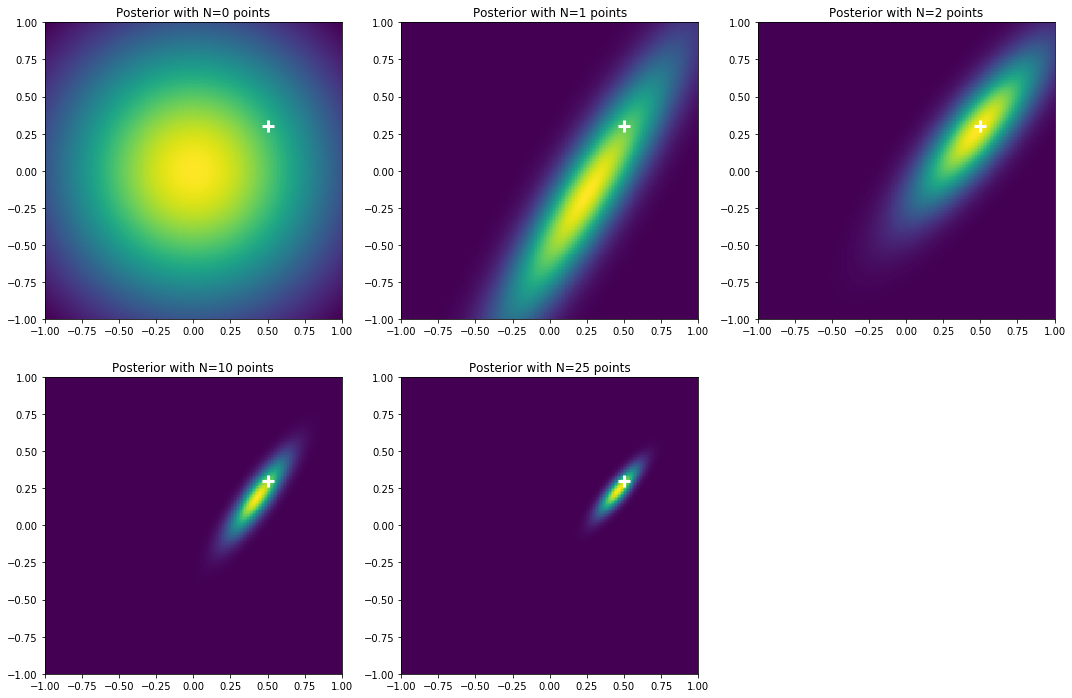

In [85]:
#TO DO: Code and visualize posterior sampling by completing code below

plt.figure(figsize=(15,10))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))
    
    phi = phi_linear(cur_data)
    
    alpha = dataset_linear['ALPHA']
    beta = dataset_linear['BETA']
    sigma_N= np.linalg.inv(alpha*np.identity(2)+beta*np.dot(phi.T,phi))
    mu_N = beta*np.dot(sigma_N,np.dot(phi.T,cur_lbl))
    
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) ) 
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z
    
    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

In [101]:
#TO DO: Code closed form solution according to the following requirements defined below

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter
      
    Returns:
      (function) prediction function, returning itself both mean and std
    """
    phi = func(X_train)
    alpha = dataset_linear['ALPHA']
    beta = dataset_linear['BETA']
    sigma_N= np.linalg.inv(alpha*np.identity(phi.shape[1])+beta*np.dot(phi.T,phi))
    mu_N = beta*np.dot(sigma_N,np.dot(phi.T,y_train))
    mu_N = mu_N.reshape(mu_N.shape[0],1)
    #print(np.shape(mu_N))
    #print(np.shape(sigma_N))
    def f_model(x) :
        
        mu = np.dot(func(x),mu_N)
        std = (1/beta) + np.dot(func(x),np.dot(sigma_N,func(x).T))
        
        return mu,np.sqrt(std)

    return f_model

In [102]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'], 
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

y_pred = np.array([])
sigma = np.array([])
for x in dataset_linear['X_test']:
    m,s = f_pred(x)
    y_pred = np.concatenate((y_pred,m[0]))
    sigma = np.concatenate((sigma,s[0]))



**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

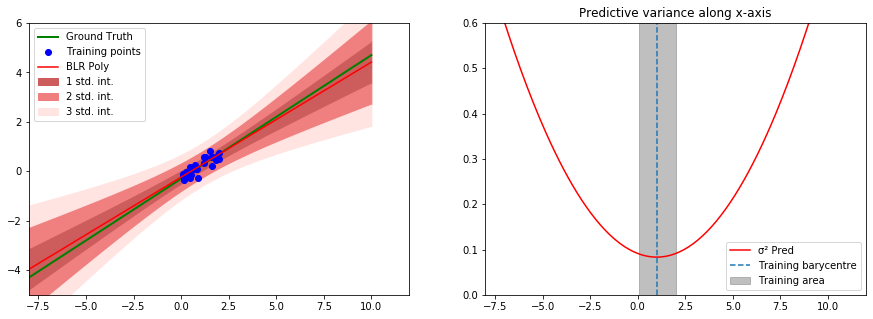

In [103]:
plot_results(dataset_linear['X_train'], dataset_linear['y_train'], dataset_linear['X_test'],dataset_linear['y_test'], y_pred, sigma,
                 xmin=-8, xmax=12, ymin=-5, ymax=6, stdmin=0, stdmax=0.6)

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

In [ ]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

In [ ]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)


# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [ ]:
# Define basis function
def phi_polynomial(x):
    """ Polynomial Basis Functions
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) polynomial features of x
    """
    D = 10
    # TO DO
    return 0

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [ ]:
#TO DO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x) :
    """ Gaussian Basis Functions
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) gaussian features of x
    """
    # TO DO
    return 0

**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**